In [1]:
import os
import torch

#%matplotlib inline
#import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
import numpy as np
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch_geometric.nn import MetaLayer
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import MessagePassing
#from torchvision import transforms
from torch_geometric.loader import DataLoader



In [2]:
import matplotlib.pyplot as plt

In [4]:
#load the loss function 
loss_omega = np.load('omega_loss_300.npz')

train_loss = loss_omega['arr_0']
valid_loss = loss_omega['arr_1']


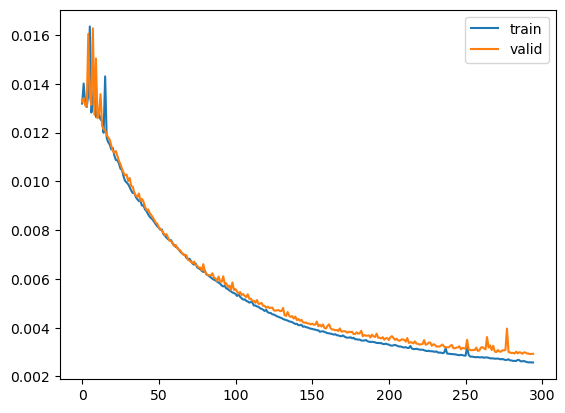

In [6]:
plt.plot(train_loss[5:], label='train')
plt.plot(valid_loss[5:], label='valid')
plt.legend()

In [8]:
print('min value of the validation loss:')
print(min(valid_loss))

min value of the validation loss:
0.0029174491524288646


In [9]:
#load test set
test_dataset = torch.load('omega_test.pt')


In [10]:
test_dataset[0]

Data(x=[45, 12], edge_index=[2, 1448], edge_attr=[1448, 1], y=0.3340499997138977, u=[1, 1])

In [13]:
class EdgeModel(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_dim):
        super().__init__()

        layers = [Linear(node_in*2 + edge_in, hidden_dim),
                  ReLU(),
                  Linear(hidden_dim, edge_out)]

        self.edge_mlp = Sequential(*layers)


    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        out = torch.cat([src, dest, edge_attr], dim=1)
        #out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        out = self.edge_mlp(out)
        return out

      
 #MPL que acutaliza el valor de los nodos
class NodeModel(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_dim):
        super().__init__()

        layers = [Linear(node_in + 3*edge_in + 1, hidden_dim),
                  ReLU(),
                  Linear(hidden_dim, node_out)]

        self.node_mlp = Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.

        row, col = edge_index
        out = edge_attr

        # Multipooling layer
        out1 = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out2 = scatter_max(out, col, dim=0, dim_size=x.size(0))[0]
        out3 = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out1, out2, out3, u[batch]], dim=1)

        out = self.node_mlp(out)
        return out

class GNN(nn.Module):
    def __init__(self, node_features, n_layers, hidden_dim, dim_out):
        super().__init__()

        self.n_layers = n_layers
        self.dim_out = dim_out
        # Number of input node features = 10
        node_in = node_features
        edge_in = 1
        edge_out = 1
        node_out = node_features
        hidden_dim = hidden_dim

        #node_in = node_out
        #edge_in = edge_out

        layers = []
        for i in range(n_layers-1):
            lay = MetaLayer(node_model=NodeModel(node_in, node_out, edge_in, edge_out, hidden_dim),
                        edge_model=EdgeModel(node_in, node_out, edge_in, edge_out, hidden_dim))
            layers.append(lay)

        self.layers = ModuleList(layers)

        self.outlayer = Sequential(Linear(3*node_out + 1, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, self.dim_out))

    def forward(self, data):
        x, edge_index, edge_attr, u = data.x, data.edge_index, data.edge_attr, data.u

        for layer in self.layers:
            #print('hello')
            x, edge_attr, _ = layer(x, edge_index, edge_attr, u, batch=data.batch)

        # Multipooling layer
        addpool = global_add_pool(x, data.batch)
        meanpool = global_mean_pool(x, data.batch)
        maxpool = global_max_pool(x, data.batch)

        out = torch.cat([addpool,meanpool,maxpool, u], dim=1)
        # Final linear layer
        out = self.outlayer(out)

        return out

model = GNN(node_features = 12, n_layers = 3, hidden_dim = 64, dim_out = 1)


In [14]:
model.load_state_dict(torch.load('model_omega_300.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [16]:
def prediction(data_pred):
    model.eval()

    pred_model = model(data_pred)    
    

    y_true = data_pred.y
    y_true_new = y_true.float()

    y_pred = pred_model

    return y_true_new, y_pred


In [17]:
true_list = []
pred_list = []
for data in test_loader:
    true, pred = prediction(data)
    pred = pred.detach().numpy()
    true = true.detach().numpy()
    true_list.append(true)
    pred_list.append(pred)
    #print(data.y)
    #print(out)

In [18]:
true_list =np.array(true_list)
pred_list =np.array(pred_list)

In [19]:
np.shape(pred_list)

(460, 1, 1)

In [20]:
pred_list = pred_list.reshape(len(pred_list),1)

Text(0.5, 1.0, 'Test set')

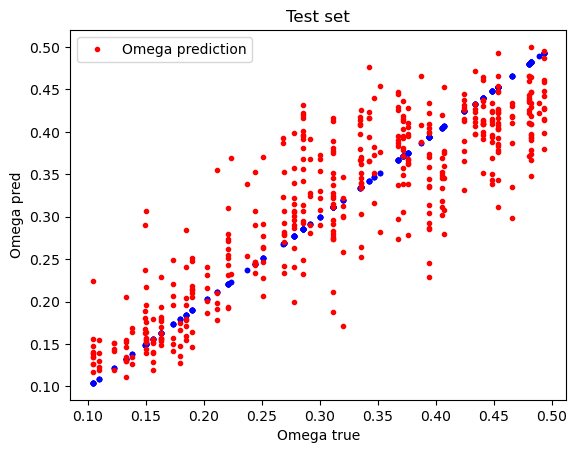

In [23]:
plt.plot(true_list, true_list, 'b.')
plt.plot(true_list, pred_list, 'r.', label='Omega prediction')
#plt.axvline(x=true_list[1,0])
plt.xlabel('Omega true')
plt.ylabel('Omega pred')
plt.legend()
plt.title('Test set')